# Membuat Classifier nya

In [1]:
    # !pip install tensorflow
# !pip install pillow

In [2]:
import tensorflow as tf

In [3]:
# Define Input Parameters
dim = (224, 224)
# dim = (456, 456)
channel = (3, )
input_shape = dim + channel

#batch size
batch_size = 64

#Epoch
epoch = 10

# Membuat dataset generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Mendefinisikan Data Generatornya

In [5]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen   = ImageDataGenerator(rescale=1. / 255)
test_datagen  = ImageDataGenerator(rescale=1. / 255)


## Mendefinisikan asal folder sumber file berasal

In [6]:
# binary = [1,0,0,0,0] [0,1,0,0,0] [0,0,1,0,0] [0,0,0,1,0] [0,0,0,0,1]
# categorical = 1,2,3,4,5

train_generator = train_datagen.flow_from_directory('cabe_final/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('cabe_final/valid/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory( 'cabe_final/test/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False  # Jangan acak urutan test data
                                                )

num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

Found 1200 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


In [7]:
print(labels)

dict_keys(['Keriting', 'Kuning', 'Layu'])


## Membuat tf.data untuk kompabilitas yang lebih baik untuk tensorflow 2.1 (tf.keras)

In [8]:
import tensorflow as tf

def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    # Mendefinisikan output_signature
    output_signature = (
        tf.TensorSpec(shape=(None, input_shape[0], input_shape[1], input_shape[2]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_class), dtype=tf.float32)
    )
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=output_signature
    )
    return tf_generator

In [9]:
# Menginisialisasi data generator
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

# Using Pre-trained model / Transfer Learning

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Memuat model VGG16 pretrained tanpa top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Menambahkan lapisan kustom untuk klasifikasi
x = base_model.output
x = Flatten()(x)  # Bisa diganti dengan GlobalAveragePooling2D jika diinginkan
x = Dense(256, activation='relu')(x)  # Dense layer pertama
x = Dropout(0.5)(x)  # Dropout dengan rate 50%
x = Dense(train_generator.num_classes, activation='softmax')(x)  # Lapisan output

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=x)

# Membekukan semua layer pada base model agar tidak dilatih ulang
for layer in base_model.layers:
    layer.trainable = False


In [11]:
from tensorflow.keras.optimizers import Adam

# Kompilasi model dengan Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


## Visualize The final model

In [12]:
# import tensorflow as tf

In [13]:
# model_viz = tf.keras.utils.plot_model(model,
#                           to_file='model.png',
#                           show_shapes=True,
#                           show_layer_names=True,
#                           rankdir='TB',
#                           expand_nested=True,
#                           dpi=55)
# model_viz

# Train Model

In [14]:
EPOCH = 20

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Menentukan callback untuk early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Memonitor validasi loss
    patience=3,          # Berhenti jika tidak ada perbaikan setelah 5 epoch
    restore_best_weights=True  # Mengembalikan bobot terbaik
)

# # (Opsional) Menyimpan model terbaik selama pelatihan
# model_checkpoint = ModelCheckpoint(
#     'best_model.h5',    # Nama file model terbaik
#     monitor='val_loss', # Memonitor validasi loss
#     save_best_only=True # Hanya menyimpan model terbaik
# )

# Training model dengan callback
history = model.fit(
    x=train_data,
    steps_per_epoch=len(train_generator),  # Total step per epoch
    epochs=EPOCH,
    validation_data=val_data,
    validation_steps=len(val_generator),  # Total step validasi
    shuffle=True, 
    verbose=1,
    callbacks=[early_stopping]  # Memasukkan callbacks
)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 281s 14s/step - accuracy: 0.5299 - loss: 3.4864 - val_accuracy: 0.9400 - val_loss: 0.1530
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 224s 12s/step - accuracy: 0.9409 - loss: 0.1684 - val_accuracy: 0.9600 - val_loss: 0.1108
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 267s 14s/step - accuracy: 0.9781 - loss: 0.0712 - val_accuracy: 0.9800 - val_loss: 0.0548
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 413s 22s/step - accuracy: 0.9920 - loss: 0.0305 - val_accuracy: 0.9800 - val_loss: 0.0344
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 410s 22s/step - accuracy: 0.9980 - loss: 0.0180 - val_accuracy: 0.9800 - val_loss: 0.0528
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 434s 23s/step - accuracy: 0.9984 - loss: 0.0170 - val_accuracy: 1.0000 - val_loss: 0.0167
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 437s 23s/step - accuracy: 0.9942 - loss: 0.0172 - val_accuracy: 0.9800 - val_loss: 0.0225
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 397s 21s/step - accuracy: 0.9980 - loss: 0.0083 - val_accuracy: 0.

In [16]:
history.history['loss']

[2.0331060886383057,
 0.14818352460861206,
 0.06429725885391235,
 0.02881539613008499,
 0.01778651960194111,
 0.01803891733288765,
 0.014303297735750675,
 0.007563681807368994,
 0.010599360801279545,
 0.009002439677715302,
 0.006156029645353556,
 0.00519306305795908,
 0.006154119037091732,
 0.003499857150018215,
 0.0026911920867860317,
 0.003589499043300748]

In [17]:
history.history['accuracy']

[0.6733333468437195,
 0.9466666579246521,
 0.9766666889190674,
 0.9925000071525574,
 0.9975000023841858,
 0.996666669845581,
 0.996666669845581,
 0.9991666674613953,
 0.9983333349227905,
 0.9991666674613953,
 0.9991666674613953,
 0.9991666674613953,
 1.0,
 1.0,
 1.0,
 1.0]

# Model Evaluation

In [18]:
loss, acc = model.evaluate(train_data, steps=len(train_generator), verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data, steps=len(test_generator), verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')    

Accuracy on training data: 1.0000 
Loss on training data: 0.0007 

Accuracy on test data: 0.9800 
Loss on test data: 0.0272 



In [19]:
# Evaluasi pada data validasi
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_generator), verbose=1)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Loss: {val_loss:.4f}')

# Evaluasi pada data uji
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')


D:\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.0084
Validation Accuracy: 1.0000
Validation Loss: 0.0084
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9800 - loss: 0.0272
Test Accuracy: 0.9800
Test Loss: 0.0272


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


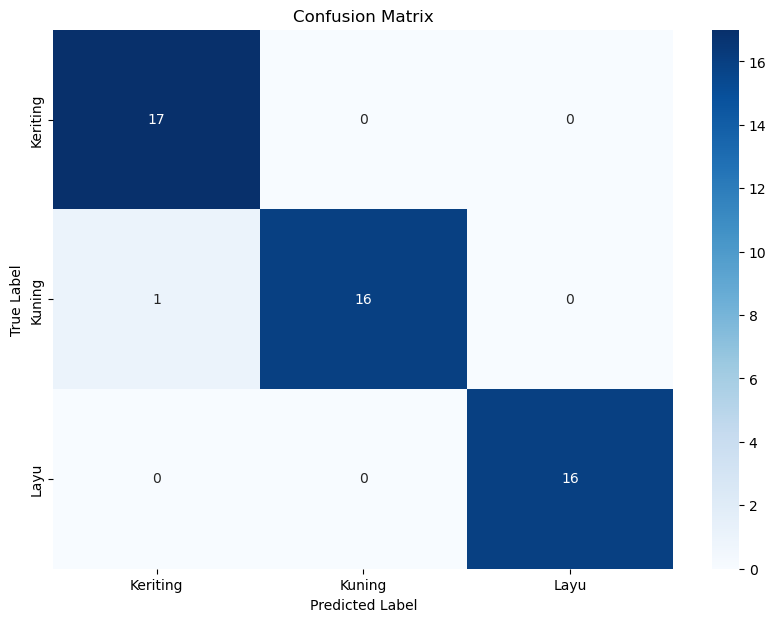

              precision    recall  f1-score   support

    Keriting       0.94      1.00      0.97        17
      Kuning       1.00      0.94      0.97        17
        Layu       1.00      1.00      1.00        16

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

Akurasi model pada data uji: 98.00%


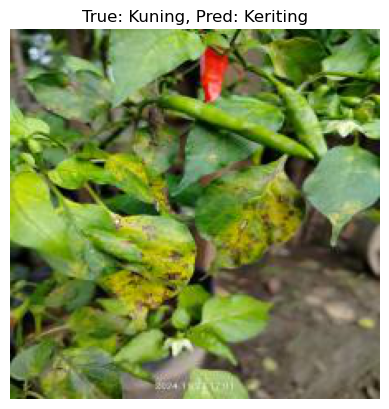

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Prediksi pada data uji
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Validasi jumlah label
y_true = test_generator.classes[:len(y_pred_classes)]  # Sinkronisasi jumlah sampel

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan classification report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

# Menghitung akurasi
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Akurasi model pada data uji: {accuracy * 100:.2f}%")

# Identifikasi prediksi yang salah
misclassified_indices = np.where(y_true != y_pred_classes)[0]

# Menampilkan gambar yang diprediksi salah beserta label yang benar dan yang diprediksi
for idx in misclassified_indices:
    # Ambil nama gambar dari generator
    img_path = test_generator.filepaths[idx]  # Nama file gambar dari test_generator
    true_label = class_labels[y_true[idx]]
    pred_label = class_labels[y_pred_classes[idx]]
    
    # Muat dan tampilkan gambar
    img = image.load_img(img_path, target_size=(224, 224))  # Sesuaikan ukuran jika diperlukan
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()


In [21]:
# Periksa jumlah sampel uji
print(f"Jumlah sampel uji dalam generator: {test_generator.samples}")

# Periksa jumlah prediksi
print(f"Jumlah prediksi: {len(y_pred)}")

# Periksa apakah jumlahnya sama
if len(y_pred) == test_generator.samples:
    print("Jumlah sampel uji dan prediksi SAMA.")
else:
    print("Jumlah sampel uji dan prediksi TIDAK SAMA.")


Jumlah sampel uji dalam generator: 50
Jumlah prediksi: 50
Jumlah sampel uji dan prediksi SAMA.


C:\Users\VERI MARPAUNG\AppData\Local\Temp\ipykernel_7536\2354461567.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


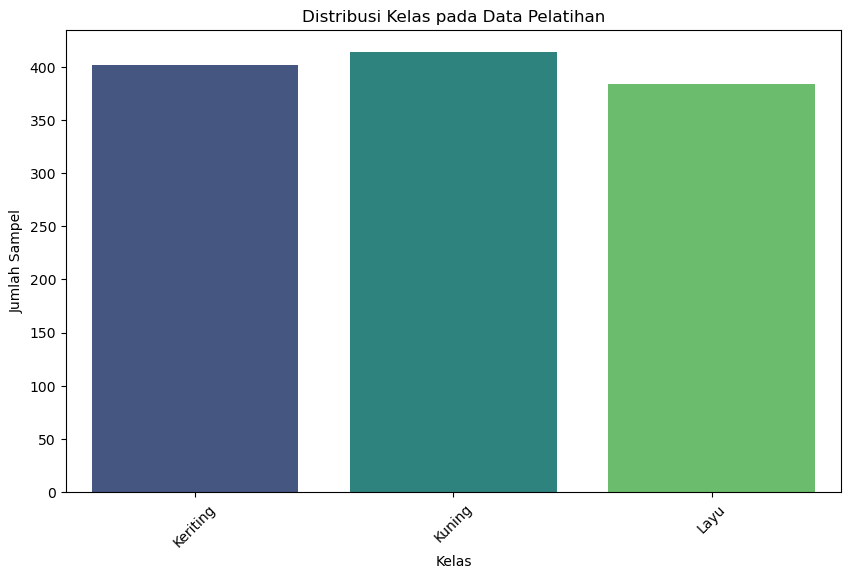

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mengambil label kelas dari train_generator
class_labels = train_generator.classes
# Menghitung jumlah data pada setiap kelas
class_counts = pd.Series(class_labels).value_counts()

# Membuat plot distribusi kelas
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribusi Kelas pada Data Pelatihan')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(ticks=range(len(class_counts)), labels=train_generator.class_indices.keys(), rotation=45)
plt.show()


# Plot the training

In [23]:
from matplotlib import pyplot as plt

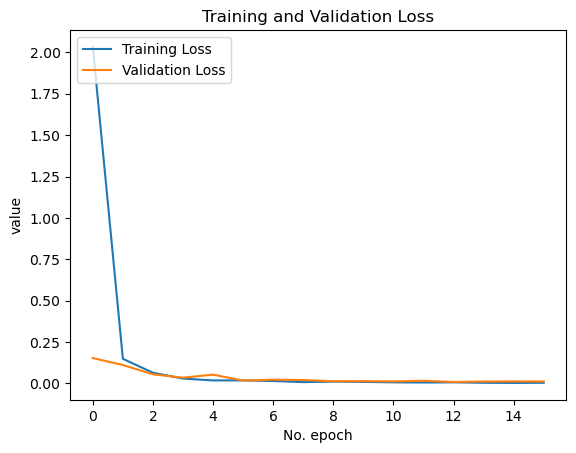

In [24]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

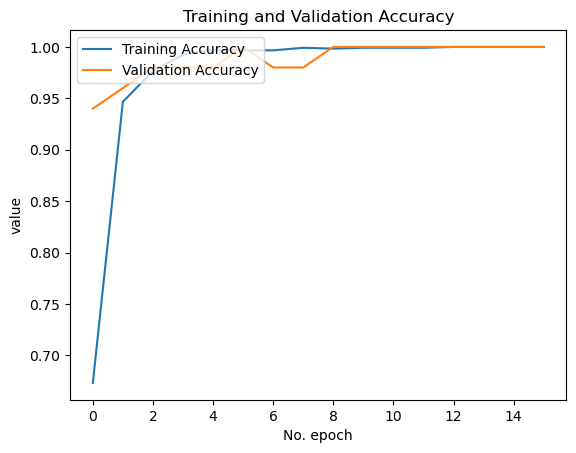

In [25]:
# Plot history: MSE
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Save Model

In [26]:
import os
import tensorflow as tf

MODEL_BASE_PATH = "model"
SAVE_MODEL_NAME = "VGG16_train_v3.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, SAVE_MODEL_NAME)

# Cek dan buat folder jika belum ada
if not os.path.exists(os.path.join(MODEL_BASE_PATH)):
    os.makedirs(os.path.join(MODEL_BASE_PATH))
    
# Menyimpan model dalam format .h5
print('Saving Model in .h5 format at {}...'.format(save_model_path))
model.save(save_model_path, include_optimizer=False)    


Saving Model in .h5 format at model\VGG16_train_v3.h5...
